<a href="https://colab.research.google.com/github/Lisenok666/OPT_DURAK/blob/main/Last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#мой код будет здесь
# пока дабавим библиотеки
from abc import get_cache_token
import pandas as pd
import random
import numpy as np
import copy
from scipy import optimize as opt
import time
from tqdm import tqdm
from numba import jit
import numba as nb
import datetime 

In [ ]:
#define test Various
TEST4 = 0
TEST5 = 0
TEST6 = 0
TEST7 = 0
GAME_FOR_STUDY = 4
BOTS_FOR_STUDY = 3
NUM_EVR_IN_COST = 4
NUM_EVR_IN_PAIR = 9
NUM_OF_EVR = 5+3+3+2
NAME_FOLDER = "Last_version/A_test"
FILE_with_iter = "Last_version/iter.txt"
evolution_iter = 5
evolution_pops = 5

In [22]:
class Deck:
    def __init__(self, Rank, Suit):
        self.deck = pd.DataFrame(1, index= Rank, columns= Suit)
        #мне показалось неплохим решением сразу создать лист карт, чтобы удобно было доставать карты
        self.posl = list()
        self.num_card = 0
        for i in Rank:
            for j in Suit:
                self.posl.append([i, j])
                self.num_card +=1
        random.shuffle(self.posl)# тасуем deck
        self.last_card = self.posl[-1]
        self.trumb = self.posl[-1][1]

    #добавил значение на вход value,чтобы мы понимали на что меняем
    def change(self, value, card_r, card_s):
        self.deck.loc[card_r[0], card_s[0]] = value

  #Добавим функцию чтобы брать карты из колоды:
    def get_ncard(self, player, n):
      if n > self.num_card:
        n = self.num_card
      for i in range(n):
        temp = self.posl[0]
        self.change(player.get_ind(), [temp[0]], [temp[1]])
        player.take_card(temp[0], temp[1])#надо написать функцию взятия карт
        self.posl.pop(0)
        self.num_card -= 1

    #Добавим функцию, чтобы взглянуть на колоду
    def show_deck(self, num = 5):
        print(self.deck.head(num))

    def who_tern(self):
      temp = self.deck.loc[:, self.trumb].values
      for i in temp:
        if i =='p1':
          return 'p1'
        if i == 'p2':
          return 'p2'

      if (random.randint(0,1)):
        return 'p1'
      else:
        return 'p2'

    def play_game(self,play1, play2, with_person = False):
      player1 = Player(self.deck.index, self.deck.columns, 'p1', play1)
      player2 = Player(self.deck.index, self.deck.columns, 'p2', play2)
      if with_person == True:
          player2 = real_Player(self.deck.index, self.deck.columns, 'p2', play2)
      self.get_ncard(player1, 6)
      self.get_ncard(player2, 6)
      turn  = self.who_tern()

      if TEST4:
        print("тест раздачи")
        print("карты первого игрока -")
        player1.show_card()
        print("карты второго игрока -")
        player2.show_card()
        print("информация игры о раздаче -" )
        self.show_deck(num = 12 )
        print("карты в колоде -", self.posl)
        turn  = self.step(turn, player1, player2)
        print(turn)
        return 0
      
      
      while(self.num_card):
        turn  = self.step(turn, player1, player2)

      result = -1

      #возможно мы как-то зациклимся поэтому добавлю
      extra_stop = 50
      while(len(player1.hand) != 0 and len(player2.hand) != 0 and extra_stop > 0):
        turn  = self.step(turn, player1, player2, with_person)
        extra_stop -=1

      if extra_stop == 0:
#         print("TUrn ", turn)
#         print("Hirst hand ", player1.hand)
#         print("Second hand ", player2.hand)
        return random.random()
      if(len(player1.hand) == 0):
        result = 0
      else:
        result  = 1
      return result
      # if turn == player1.get_ind():
      #   turn = 0
      # else:
      #   turn = 1
      
      if TEST7:
        print("чей ход", turn)
        print("карты у первого игрока", player1.hand)
        print("карты у second игрока", player2.hand)
        print("козырь", self.trumb)
        print("козырь", self.trumb)
        #result = who_win(turn, [player1.hand, player2.hand], self.trumb, list())
        result = -1
        while(len(player1.hand) != 0 and len(player2.hand) != 0):
          turn  = self.step(turn, player1, player2)
        if(len(player1.hand) == 0):
          result = 0
        else:
          result  = 1
        print("кто победил?", result)
        return result

      #result = who_win(turn, [player1.hand, player2.hand], self.trumb,list())

          

    def step(self, turn, p1, p2, with_person = False):
      if with_person == True:
        print("Bot hand = ", p1.hand)
      opp_index = turn
      if turn == p1.get_ind():
        player1 = p1
        player2 = p2
        opp_index = p2.get_ind()
      else:
        player1 = p2
        player2 = p1
        opp_index = p1.get_ind()

      table = list()
      attack_card = player1.decition_attack(table, self.num_card, self.last_card)
      table.append(attack_card)
      deffence_card = player2.decition_defence(table, self.num_card, self.last_card)
      print("Defence card = ", deffence_card)
      if deffence_card != 'take':
        table.append(deffence_card)

      if TEST4:
        print("card attack", attack_card)
        print("card defence", deffence_card)
        print("на столе", table)
        print("_____")

      while(attack_card != 'stop' and deffence_card !='take'):
          attack_card = player1.decition_attack(table, self.num_card, self.last_card)
          if attack_card == 'stop':
            turn = opp_index
            break
          table.append(attack_card)
          deffence_card = player2.decition_defence(table, self.num_card, self.last_card)
          if deffence_card != 'take':
            table.append(deffence_card)
          elif len(player2.hand) == 0:
            turn = opp_index
          if TEST4:
            print("card attack", attack_card)
            print("card defence", deffence_card)
            print("на столе", table)
            print("_____")

      
      if turn == opp_index:
        #card_take = int(len(table)/2)
        self.get_ncard(player1, max(6 - len(player1.hand), 0))
        self.get_ncard(player2, max(6 - len(player2.hand), 0))
        for card in table:
          if card in player1.oponent_hand:
            player1.oponent_hand.remove(card)
          if card in player2.oponent_hand:
            player2.oponent_hand.remove(card)
          player1.deck.loc[card[0], card[1]] = -1
          player2.deck.loc[card[0], card[1]] = -1
          self.change(-1, [card[0]], [card[1]])

      else:
        for i in range(len(player2.hand)):
           if with_person == True:
               print('Добавить карту')
           temp_card = player1.decition_attack(table, self.num_card, self.last_card)
           if temp_card != 'stop':
            table.append(temp_card)
           else:
            break
            
        for card in table:
          player2.hand.append(card)
          if card not in player1.oponent_hand:
            player1.oponent_hand.append(card)
            player1.deck.loc[card[0], card[1]] = opp_index
          if card in player2.oponent_hand:
            player2.oponent_hand.remove(card)
            player2.deck.loc[card[0], card[1]] = player2.ind
          self.change(opp_index, [card[0]], [card[1]])
          
        # for card in want_to_add:
        #   player2.hand.append(card)
        #   if card not in player1.oponent_hand:
        #     player1.oponent_hand.append(card)
        #     player1.deck.loc[card[0], card[1]] = player1.ind
        #   if card in player2.oponent_hand:
        #     player2.oponent_hand.remove(card)
        #     player2.deck.loc[card[0], card[1]] = opp_index
        #   self.change(opp_index, [card[0]], [card[1]])

        card_take = int(len(table)/2) +1
        self.get_ncard(player1, max(6 - len(player1.hand), 0))
        
      return turn




In [ ]:
import sys
class real_Player:
    def __init__(self, Rank, Suit, my_ind, evristic):
        self.deck = pd.DataFrame(1, index= Rank, columns= Suit)
        self.ind = my_ind
        self.hand = list()
        self.oponent_hand = list()
        self.evristic = evristic

    def decition_add(self,table, num_of_card, last_card, can_dop):
      ranks = [card[0] for card in table]
      can_add = [card for card in self.hand if card[0] in ranks]
      if can_dop == 0 or len(can_add) == 0:
        return list()
      combination = comb(len(can_add), can_dop)
      deck_list, n_opHand = self.get_card_in_deck_n_opHand()
      if num_of_card:
          avarage_deck_cost = (CardCost(deck_list, self.evristic[0], last_card[1], num_of_card)+trumpBonus(deck_list, self.evristic[4], last_card[1]))/num_of_card
          avarage_deck_cost = (self.evristic[5] + (self.evristic[6]*rank_to_int(last_card[0])+ self.evristic[7]) * (num_of_card - len(table))) * avarage_deck_cost
      else: 
          avarage_deck_cost = 10000
      we_get = max(6-len(self.hand), 0)
      new_cost = list()

      for com in combination:
        new_hand =  copy.deepcopy(can_add)
        for i in com:
          new_hand.remove(can_add[i])
        #какого хуя we_get a не min(len(com), we_get)
        new_cost.append(my_cost(new_hand, self.evristic, last_card[1], num_of_card) + avarage_deck_cost * min(we_get, len(com)))
      com_best = combination[np.argmax(new_cost)] 
      add_card = list()

      for ind in com_best:
        add_card.append(can_add[ind])

      for card in add_card:
        self.hand.remove(card)
      return add_card


    def decition_attack(self,table, num_of_card, last_card):
        
        print("You Attack and info", num_of_card, last_card)
        print("Your hand ", self.hand)
        print("Table ", table)        
        
        if len(table) == 0:       
            print("введите номер карты начиная с нуля")
            number_of_card = int(input())
            while(number_of_card< 0 or number_of_card >= len(self.hand)):
                print('incorrect number')
                print("Число должно быть меньше ", len(self.hand))
                number_of_card = int(input())
            card_attack = self.hand[number_of_card] 

        else:
            ranks = [card[0] for card in table]
            can_add = [card for card in self.hand if card[0] in ranks]
            if len(can_add) == 0:
                print("Вы не можете добавить карту")
                return 'stop'
            print("введите 1 если хотите продолжить атаку и ноль иначе")
            number_of_card = int(input())
            while(number_of_card not in [0, 1]):
                print("Число должно быть 1 или 0 ")
                number_of_card = int(input())
            if number_of_card == 1:
                print("введите номер карты начиная с нуля")
                number_of_card = int(input())
                while((number_of_card< 0 or number_of_card >= len(self.hand)) or self.hand[number_of_card] not in can_add) :
                    print('incorrect number')
                    print("Число должно быть меньше и карту мы должны иметь возможность подложить", len(self.hand))
                    print("Список возможных карт ", can_add)
                    number_of_card = int(input())
            else:
                return 'stop'
            card_attack = self.hand[number_of_card]
        
        self.hand.remove(card_attack)
        return card_attack

    def decition_defence(self, table, num_of_card, last_card):
        #чем мы можем отбить
        print("Your hand ", self.hand)
        print("You Defence and info", num_of_card, last_card)
        print("Your hand ", self.hand)
        print("Table ", table)
        can_bit = [card for card in self.hand if (rank_to_int(card[0]) > rank_to_int(table[-1][0]) and card[1] == table[-1][1]) or (card[1] == last_card[1] and table[-1][0]!= last_card[1])]
        if len(can_bit) == 0:
            print("You can't bit")
            return 'take'
        
        print("введите 1 если хотите отбиться и 0 иначе")
        number_of_card = int(input())
        while(number_of_card not in [0, 1]):
            print("Число должно быть 1 или 0 ")
            number_of_card = int(input())
            
        if number_of_card == 1:
            number_of_card = int(input())
            while((number_of_card< 0 or number_of_card >= len(self.hand)) or self.hand[number_of_card] not in can_bit) :
                    print('incorrect number')
                    print("Число должно быть меньше и карту мы должны иметь возможность подложить", len(self.hand))
                    print("Список возможных карт ", can_bit)
                    number_of_card = int(input())
        else:
            return 'take'
        card_defence = self.hand[number_of_card]
        self.hand.remove(card_defence)
        return card_defence

        
    def take_card(self, Rank, Suit):
      self.deck.loc[Rank, Suit] = self.ind
      self.hand.append([Rank, Suit])

    def get_card_in_deck_n_opHand(self):
      deck_to_list, n_oponent = list(), 0
      for i in self.deck.index:
        for j in self.deck.columns:
          if self.deck.loc[i, j] == 1:
            deck_to_list.append([i, j])
          elif self.deck.loc[i, j] not in [-1,1,self.ind]:
            n_oponent += 1
      return deck_to_list, n_oponent

    def get_ind(self):
      return self.ind

    def card_coupling(self, trumb, card_in_deck, table, atack_or_def = 'atack'):
      p_coupl = np.zeros(len(self.hand))
      p_cover = np.zeros(len(self.hand))
      opp_ranks = [i[0] for i in self.oponent_hand]
      tab_ranks = [i[0] for i in table]
      ranks = [i[0] for i in self.hand]
      for card in self.hand:
        can_coupl = [i for i in card_in_deck if (rank_to_int(i[0]) > rank_to_int(card[0]) and i[1] == card[1]) or (card[1] != trumb and i[1] == trumb)]
        common = [i for i in can_coupl if i[0] in ranks]
        if TEST6:
          print(card)
          print(can_coupl)
          print(common)
          print("________")
        if len(can_coupl) == 0:
          p_coupl[self.hand.index(card)] = 0
        else:
          #атакующий случай
          if atack_or_def == 'atack' and card[0] in opp_ranks:
            p_coupl[self.hand.index(card)] += 5 
          if atack_or_def == 'atack':
            sum_ranks = -1
            for i in self.hand:
              if i[0] in ranks:
                sum_ranks +=1
            p_coupl[self.hand.index(card)] += sum_ranks*50 

          #защищающий случай
          if atack_or_def == 'def' and card[0] in opp_ranks:
            p_coupl[self.hand.index(card)] += 10  
          if atack_or_def == 'def' and card[0] in tab_ranks:
            p_coupl[self.hand.index(card)] += 20  
          p_coupl[self.hand.index(card)] = len(common)
      return p_coupl
    
    def show_card(self):
      print(self.hand)
    


In [ ]:
class Player:
    def __init__(self, Rank, Suit, my_ind, evristic):
        self.deck = pd.DataFrame(1, index= Rank, columns= Suit)
        self.ind = my_ind
        self.hand = list()
        self.oponent_hand = list()
        self.evristic = evristic

    def decition_add(self,table, num_of_card, last_card, can_dop):
      ranks = [card[0] for card in table]
      can_add = [card for card in self.hand if card[0] in ranks]
      if can_dop == 0 or len(can_add) == 0:
        return list()
      combination = comb(len(can_add), can_dop)
      deck_list, n_opHand = self.get_card_in_deck_n_opHand()
      if num_of_card:
          avarage_deck_cost = (CardCost(deck_list, self.evristic[0], last_card[1], num_of_card)+trumpBonus(deck_list, self.evristic[4], last_card[1]))/num_of_card
          avarage_deck_cost = (self.evristic[5] + (self.evristic[6]*rank_to_int(last_card[0])+ self.evristic[7]) * (num_of_card - len(table))) * avarage_deck_cost
      else: 
          avarage_deck_cost = 10000
      we_get = max(6-len(self.hand), 0)
      new_cost = list()

      for com in combination:
        new_hand =  copy.deepcopy(can_add)
        for i in com:
          new_hand.remove(can_add[i])
        #какого хуя we_get a не min(len(com), we_get)
        new_cost.append(my_cost(new_hand, self.evristic, last_card[1], num_of_card) + avarage_deck_cost * min(we_get, len(com)))
      com_best = combination[np.argmax(new_cost)] 
      add_card = list()

      for ind in com_best:
        add_card.append(can_add[ind])

      for card in add_card:
        self.hand.remove(card)
      return add_card


    def decition_attack(self,table, num_of_card, last_card):
        our_cost = my_cost(self.hand, self.evristic, last_card[1], num_of_card)
        deck_list, n_opHand = self.get_card_in_deck_n_opHand()
        #оцениваем стоимость карт из колоды
        if num_of_card:
          avarage_deck_cost = (CardCost(deck_list, self.evristic[0], last_card[1], num_of_card)+trumpBonus(deck_list, self.evristic[4], last_card[1]))/num_of_card
          avarage_deck_cost = (self.evristic[5] + (self.evristic[6]*rank_to_int(last_card[0])+ self.evristic[7]) * (num_of_card - len(table))) * avarage_deck_cost
        else: 
          avarage_deck_cost = 10000
        oponent_cost = (my_cost(self.oponent_hand, self.evristic, last_card[1], num_of_card) + (len(self.oponent_hand) - n_opHand)*avarage_deck_cost)

        
        
        if len(table) == 0:
          #p_coupling = self.card_coupling(last_card[1],deck_list)          
          new_cost = list()
          for card in self.hand:
            prob_new_h = [i for i in self.hand if i != card]
            new_cost.append(my_cost(prob_new_h, self.evristic, last_card[1], num_of_card))
          card_attack = self.hand[np.argmax(new_cost)] 

        else:
          new_cost = list()
          ranks = [card[0] for card in table]
          can_add = [card for card in self.hand if card[0] in ranks]
          if len(can_add) == 0:
            return 'stop'

          coupl = self.card_coupling(last_card[1], deck_list, table)
          for card in can_add:
            prob_new_h = [i for i in self.hand if i != card]
            k = (2+ self.evristic[14] * len(self.oponent_hand)*coupl[self.hand.index(card)])
            new_cost.append(my_cost(prob_new_h, self.evristic, last_card[1], num_of_card) + k*avarage_deck_cost)
          if np.argmax(new_cost) < our_cost:
              return 'stop'
          card_attack = can_add[np.argmax(new_cost)]
        
        self.hand.remove(card_attack)
        return card_attack

    def decition_defence(self, table, num_of_card, last_card):
        #чем мы можем отбить
        can_bit = [card for card in self.hand if (rank_to_int(card[0]) > rank_to_int(table[-1][0]) and card[1] == table[-1][1]) or (card[1] == last_card[1] and table[-1][0]!= last_card[1])]
        if TEST4:
          print("что нужно отбить", table[-1])
          print("наша рука", self.hand)
          print("нам подходит", can_bit)
          print("___________")
        if len(can_bit) == 0:
          return 'take'
        deck_list, n_opHand = self.get_card_in_deck_n_opHand()
        #стоимость карт в колоде
        if num_of_card:
          avarage_deck_cost = (CardCost(deck_list, self.evristic[0], last_card[1], num_of_card)+trumpBonus(deck_list, self.evristic[4], last_card[1]))/num_of_card
          avarage_deck_cost = (self.evristic[8] + (self.evristic[9]*rank_to_int(last_card[0])+ self.evristic[11]) * (num_of_card - len(table))) * avarage_deck_cost
        else: 
          avarage_deck_cost = 10000
        
        #поймём хотим ли мы отбиваться, какая у нас рука будет, если заберём карты
        new_hand_be = copy.deepcopy(table)
        for card in self.hand:
          new_hand_be.append(card)
        new_hand_be_cost = my_cost(new_hand_be, self.evristic, last_card[1], num_of_card)
        coupl = self.card_coupling(last_card[1], deck_list, table, 'def')
        new_cost = list()
        for card in can_bit:
            prob_new_h = [i for i in self.hand if i != card]
            k = (1+ self.evristic[12] * len(self.oponent_hand)*coupl[self.hand.index(card)])
            #звизде+пиздец где avarage_deck _cost надо добавить
            new_cost.append(k* my_cost(prob_new_h, self.evristic, last_card[1], num_of_card) + len(table)*0.5*avarage_deck_cost)
        if (1+ self.evristic[13]*num_of_card)*new_hand_be_cost > np.argmax(new_cost):
          return 'take'
        card_defence = can_bit[np.argmax(new_cost)]
        self.hand.remove(card_defence)
        return card_defence

        
    def take_card(self, Rank, Suit):
      self.deck.loc[Rank, Suit] = self.ind
      self.hand.append([Rank, Suit])

    def get_card_in_deck_n_opHand(self):
      deck_to_list, n_oponent = list(), 0
      for i in self.deck.index:
        for j in self.deck.columns:
          if self.deck.loc[i, j] == 1:
            deck_to_list.append([i, j])
          elif self.deck.loc[i, j] not in [-1,1,self.ind]:
            n_oponent += 1
      return deck_to_list, n_oponent

    def get_ind(self):
      return self.ind

    def card_coupling(self, trumb, card_in_deck, table, atack_or_def = 'atack'):
      p_coupl = np.zeros(len(self.hand))
      p_cover = np.zeros(len(self.hand))
      opp_ranks = [i[0] for i in self.oponent_hand]
      tab_ranks = [i[0] for i in table]
      ranks = [i[0] for i in self.hand]
      for card in self.hand:
        can_coupl = [i for i in card_in_deck if (rank_to_int(i[0]) > rank_to_int(card[0]) and i[1] == card[1]) or (card[1] != trumb and i[1] == trumb)]
        common = [i for i in can_coupl if i[0] in ranks]
        if TEST6:
          print(card)
          print(can_coupl)
          print(common)
          print("________")
        if len(can_coupl) == 0:
          p_coupl[self.hand.index(card)] = 0
        else:
          #атакующий случай
          if atack_or_def == 'atack' and card[0] in opp_ranks:
            p_coupl[self.hand.index(card)] += 5 
          if atack_or_def == 'atack':
            sum_ranks = -1
            for i in self.hand:
              if i[0] in ranks:
                sum_ranks +=1
            p_coupl[self.hand.index(card)] += sum_ranks*50 

          #защищающий случай
          if atack_or_def == 'def' and card[0] in opp_ranks:
            p_coupl[self.hand.index(card)] += 10  
          if atack_or_def == 'def' and card[0] in tab_ranks:
            p_coupl[self.hand.index(card)] += 20  
          p_coupl[self.hand.index(card)] = len(common)
      return p_coupl
    
    def show_card(self):
      print(self.hand)
    


In [ ]:
def who_win(turn, hands,  trumb, table):
  global iter
  global win0
  global win1
  iter += 1
  if iter > 10**3:
    return random.randint(0,1)
  if len(hands[0]) == 0:
    return 0
  if len(hands[1]) == 0:
    return 1
  ranks = [card[0] for card in table]
  can_add = [card for card in hands[turn] if card[0] in ranks]
  new_table = copy.deepcopy(table)
  new_hand = copy.deepcopy(hands)

  if len(new_table) == 0:
    for card in new_hand[turn]:
      table1 =  copy.deepcopy(new_table)
      new_hand1 =  copy.deepcopy(new_hand)
      table1.append(card)
      new_hand1[turn].remove(card)
      who_win1 = who_win(turn = turn, hands = new_hand1, trumb = trumb, table = table1)
      if who_win1 == turn:# наше решение привело к победе, значит мы в выйгрышной позиции находились на преведущем шаге
        return who_win1
    return abs(turn - 1)#ни однонаше решение не привело к победе, значит мы в проигрышном положении

  elif len(new_table)%2 == 1:
    #print("____", new_table[-1])
    can_bit = [card for card in new_hand[turn-1] if (rank_to_int(card[0]) > rank_to_int(new_table[-1][0]) and card[1] == new_table[-1][1]) or (card[1] == trumb and new_table[-1][0]!= trumb)]
    for card in can_bit:
      table1 =  copy.deepcopy(new_table)
      new_hand1 =  copy.deepcopy(hands)
      table1.append(card)
      new_hand1[turn-1].remove(card)
      who_win1 = who_win(turn = turn, hands = new_hand1,  trumb = trumb, table = table1)
      if who_win1 != turn:# мы отбились этой картой и победили
        return who_win1

    #если мы здесь, то как бы мы не отбивались, мы проиграли, значит нужно брать карты
    ##забираем карты и что нам могут подкинуть
    can_dop = len(new_hand[turn-1])
    for card in new_table:
      new_hand[turn-1].append(card)
    new_table = list()  
    who_win1 = who_win(turn = turn, hands = new_hand,  trumb = trumb, table = new_table)
    if who_win1 == turn:# подбрасывать, это решение того кто ходит
        return who_win1
    combination = comb(len(can_add), can_dop)
    for com in combination:
      new_hand1 =  copy.deepcopy(new_hand)
      for i in com:
        new_hand1[turn-1].append(can_add[i])
        new_hand1[turn-1].remove(can_add[i])
      who_win1 = who_win(turn = turn, hands = new_hand1, trumb = trumb, table = new_table) 
      if who_win1 == turn:# подбрасывать, это решение того кто ходит
        return who_win1
    #если мы всё ещё в функции, значит что бы мы не подкинули(в том числе ничего) мы проиграем
    return abs(turn - 1)
  ####
  else:
    #решили не подбрасывать
    new_turn = abs(turn - 1)
    table1 =  list()
    who_win1 = who_win(turn = new_turn, hands = new_hand,  trumb = trumb, table = table1)
    if who_win1 == turn:# не подбрасывать, это наше решение
        return who_win1
    #решили подбросить
    for card in can_add:
      table1 =  copy.deepcopy(new_table)
      new_hand1 =  copy.deepcopy(new_hand)
      new_hand1[turn].remove(card)
      table1.append(card)
      who_win1 = who_win(turn = turn, hands = new_hand1,  trumb = trumb, table = table1)
      if who_win1 == turn:# не подбрасывать, это наше решение
        return who_win1
    #если мы всё ещё в функции, значит что бы мы не подкинули(в том числе ничего) мы проиграем
    return abs(turn - 1)

In [ ]:
def comb(numb, com):
  can_be = list()
  temp_ind = np.zeros(com, dtype=int)
  count = 0
  while(count < com):
      if len(can_be) == 0:
        for j in range(numb):
          temp_ind[count] = j
          t = temp_ind.copy()
          can_be.append(t)
      else:
        tem_list = list()
        for comb in can_be:
          for j in range(numb):
            if j >= comb[count-1]:
              t = comb.copy()
              t[count] = j
              tem_list.append(t)
        for comb in tem_list:
          can_be.append(comb)
        
      count +=1
  variant = np.unique(np.array(can_be), axis = 0)
  answer = list()
  for var in variant:
    answer.append(list(np.unique(var)))

  cor_answer = list()
  for ans in answer:
    if ans not in cor_answer:
      cor_answer.append(ans)
  return cor_answer
  

In [ ]:
def CardCost(hand,evristic1, trumbSuit, card_in_deck):
  CardCoast = 0
  card_in_hand = len(hand)
  for i in hand:
    is_trumb = 0
    if i[1] == trumbSuit:
      is_trumb = 1
    CardCoast = (evristic1[0] + evristic1[1]* is_trumb + evristic1[2]*card_in_deck + evristic1[3]*card_in_hand)*rank_to_int(i[0])
  return CardCoast

def PairCost(hand, evristic2):
  PairCost = 0
  pairs = list()
  uniq_rank = list()
  for i in hand:
    if i[0] not in uniq_rank:
      uniq_rank.append(i[0])
      pairs.append(list())

  for i in hand:
      pairs[uniq_rank.index(i[0])].append(i)
  
  for pair in pairs:
    PairCost += (len(pair)-1)*rank_to_int(pair[0][0])*evristic2[rank_to_int(pair[0][0]) - 6]
  return PairCost

def rankSpread(hand,evristic3):
  rankS = 0
  for i in hand:
    for j in hand:
      r1 = rank_to_int(i[0])
      r2 = rank_to_int(j[0])
      rankS+=abs(r1-r2)
  return evristic3*rankS

def scatterBySuit(hand,evristic4):
  eqSuit = 0
  for i in hand:
    for j in hand:
      if i != j and i[1] == j[1]:
        eqSuit += 1
  return evristic4*eqSuit

def trumpBonus(hand,evristic5, trumbSuit, ):#нужна информация о козырной масти
  trumpBonus = 0
  for i in hand:
    if i[1] == trumbSuit:
      trumpBonus += evristic5*rank_to_int(i[0])#подумаем что делать с этой эвристикой
  return trumpBonus

def rank_to_int(r):
  if r in ['J', 'Q', 'K', 'A']:
    if r =='J':
      return 11
    elif r == 'Q':
      return 12
    elif r =='K':
      return 13
    else:
      return 14
  else:
    return int(r)

def my_cost(hand, evristic,trumbSuit, card_in_deck, full_info = False):
      CardCost1 = CardCost(hand,evristic[0],trumbSuit, card_in_deck)
      PairCost1 = PairCost(hand,evristic[1])
      rankSpread1 = rankSpread(hand,evristic[2])
      scatterBySuit1 = scatterBySuit(hand,evristic[3])
      trumpBonus1 = trumpBonus(hand,evristic[4], trumbSuit)
      if full_info == True:
        print('CardCost = ', CardCost1)
        print('PairCoast = ', PairCost1)
        print('rankSpread = ', rankSpread1)
        print('scatterBySuit = ', scatterBySuit1)
        print('trumpBonus = ', trumpBonus1)
      cost = CardCost1+PairCost1+rankSpread1+scatterBySuit1+trumpBonus1
      return cost



In [ ]:
def get_evr():#случайный набор эвристик
  evr1 = np.random.randint(1, 20, NUM_EVR_IN_COST)
  evr2 = np.random.randint(1, 10, NUM_EVR_IN_PAIR)
  evr = [evr1, evr2]
  for i in range(len(evr), len(evr) + NUM_OF_EVR):
    evr.append(random.randint(-10,10)) 
  return evr

def from_evr_to_vek(evr):
  razm = list()
  for i in range(2):
    for j in list(evr[i]):
      razm.append(j)
  for i in range(2, 2 +  NUM_OF_EVR):
    razm.append(evr[i])
  return razm


def x_to_evr(x):
  evr1 = list()
  evr2 = list()
  for i in range(NUM_EVR_IN_COST):
    evr1.append(x[i])

  for i in range(NUM_EVR_IN_COST, NUM_EVR_IN_COST+NUM_EVR_IN_PAIR):
    evr2.append(x[i])

  evristic = [evr1, evr2]
  for i in range(len(evristic), len(evristic) +NUM_OF_EVR):
    evristic.append(x[i])
  return evristic


def opt_fuction(x, A, B):
  global iter
  our_evr = x_to_evr(x)
  num_of_win = 0
  suit = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
  rank = ['6','7','8','9','10', 'J', 'Q', 'K', 'A']
  for evr in A:
    for i in range(GAME_FOR_STUDY):
      temp = Deck(rank, suit)
      num_of_win +=  temp.play_game(evr, our_evr)
      iter = 0
  res = num_of_win/(GAME_FOR_STUDY*len(A))
  if res > B[np.argmin(B, axis = 0)[1]][1]:
    B.remove(B[np.argmin(B, axis = 0)[1]])
    B.append([our_evr, res])
  return -res

In [ ]:
suit = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
rank = ['6','7','8','9','10', 'J', 'Q', 'K', 'A']
temp = Deck(rank, suit)
best_bot = [-2.717252, -4.612805, -3.846342, -9.613779, -1.177467,  1.331127, -2.782833,
  1.194872,  6.167775, -4.521589,  2.874314,  8.842318, -6.018356, -3.846342,
 -9.613779, -1.177467,  1.331127, -2.782833,  1.194872,  6.167775, -4.521589,
  2.874314,  8.842318, -6.018356, -0.952097,  9.952817]
res = temp.play_game(x_to_evr(best_bot), x_to_evr(best_bot), True)
if res == 1:
  print("YOU WIN!!!")
else:
  print("YOU LOSE!!!")

In [ ]:
x = get_evr()
hand = ['A', 'Spades'], ['A', 'Hearts'], ['9', 'Clubs'], ['10', 'Spades'], ['6', 'Diamonds'], ['K', 'Hearts']
trumb = 'Clubs'
n_deck = 20
my_cost(hand,x, trumb, n_deck, full_info=True)

CardCost =  3640
PairCoast =  42
rankSpread =  812
scatterBySuit =  8
trumpBonus =  90


4592

In [ ]:
%%time
B = list()
for i in range(10):
  B.append([list(),0])
for j in tqdm(range(10)):
  a = np.random.randint(1, 10, 30)
  iter  = 0
  A = list()
  for i in range(BOTS_FOR_STUDY):
    A.append(get_evr())
  opt_fuction(a, A, B)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]

Wall time: 28.1 s


In [ ]:
%%time
def Test7(full_info = 1): # класс карты розданы игрокам,
  global TEST7
  TEST7 = full_info
  suit = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
  rank = ['6','7','8','9','10', 'J', 'Q', 'K', 'A']
  temp = Deck(rank, suit)
  print(temp.play_game(get_evr(), get_evr()))
  TEST7 = 0

def Test5():
  global TEST5
  TEST5 = 1
  suit = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
  rank = ['6','7','8','9','10', 'J', 'Q', 'K', 'A']
  hand = ['A', 'Spades'], ['A', 'Hearts'], ['9', 'Clubs'], ['10', 'Spades'], ['6', 'Diamonds'], ['K', 'Hearts']
  temp_p  = Player(rank, suit, 'p1', get_evr())

  for card in hand:
    temp_p.take_card(card[0], card[1])

  print(temp_p.decition_attack(list(), 20, np.array(['7', 'Spades'])))
  print("_____")
  print(temp_p.want_to_add([['K', 'Spades'], ['K', 'Clubs']], 20, np.array(['7', 'Spades']), 3))
  TEST5 = 0
suit = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
rank = ['6','7','8','9','10', 'J', 'Q', 'K', 'A']
temp = Deck(rank, suit)
print(temp.play_game(get_evr(), get_evr()))

1
Wall time: 190 ms


In [ ]:
def Tournament(B):
  players = np.zeros(len(B))
  suit = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
  rank = ['6','7','8','9','10', 'J', 'Q', 'K', 'A']
  for i in range(len(B)):
    games = 0
    for j in range(i,len(B)):
      if i!=j:
        for k in range(10):
          games += 1
          temp = Deck(rank, suit)
          res = temp.play_game(B[j], B[i])
          players[i] +=res
          players[j] +=abs(res-1)
  C = list()
  for i in range(BOTS_FOR_STUDY):
    C.append(B[np.argmax(players)])
    B.pop(np.argmax(players))
    players = np.delete(players, np.argmax(players))
  return C



In [ ]:
def save_resA(A, iter):
  for i in range(len(A)):
    np.savetxt(NAME_FOLDER+str(iter)+ '_bot'+str(i)+'.txt', from_evr_to_vek(A[i]), fmt='%f')
def read_resA(iter):
  res_bots = list()
  for i in range(BOTS_FOR_STUDY):
    res_bots.append(np.loadtxt(NAME_FOLDER+str(iter)+ '_bot'+str(i)+'.txt', dtype=float))
  return res_bots

In [ ]:
from os import write
START1 = 0
if START1 == 1:
  f = open(FILE_with_iter, 'w+')
  f.write(str(-1)+ '\n')
  f.close()

def write_iter(st):
  f = open(FILE_with_iter, 'w+')
  f.write(str(st)+ '\n')
  f.close()

def get_st():
  f = open(FILE_with_iter, 'r+')
  l = [line.strip() for line in f]
  f.close()
  return int(l[0])

In [ ]:
%%time
START = 1
if START == 1:
  A = list()
  st = 0
  evr0 = from_evr_to_vek(get_evr())
    if get_st() == -1:
    for i in range(BOTS_FOR_STUDY):
      A.append(get_evr())
    save_resA(A, st)
    compare = list(copy.deepcopy(A))
    for i in range(BOTS_FOR_STUDY):
      compare.append(get_evr())
    compare = [compare[i]  for i in range((len(compare) - 1), -1, -1)]
  else:
    st = get_st()
    print(st)
    prevA = read_resA(st)
    for i in prevA:
      A.append(x_to_evr(i))
    compare = list(copy.deepcopy(A))
    prevA = read_resA(st-1)
    for i in prevA:
      compare.append(x_to_evr(i))
    compare = [compare[i]  for i in range((len(compare) - 1), -1, -1)]

  for j in range(2):
    B = list()
    for i in range(BOTS_FOR_STUDY*5):
      B.append([list(),0])
    bounds1 =list()
    for j in range(NUM_EVR_IN_COST + NUM_EVR_IN_PAIR + NUM_OF_EVR):
      bounds1.append((-10,10))
    result1 = opt.differential_evolution(opt_fuction, bounds  = bounds1,  args=(A, B),  maxiter=evolution_iter, popsize = evolution_pops) 
    for i in range(BOTS_FOR_STUDY*5):
      B[i] = B[i][0]
    
    A = Tournament(list(np.vstack((compare,B))))
    compare = list(np.vstack((compare,A)))[BOTS_FOR_STUDY:]
    save_resA(A, st+1)
    st +=1
    write_iter(st)
    print("iter")
    print("_______")

8
iter
_______
iter
_______
Wall time: 2h 50min 33s


In [ ]:
RES_A = list()
for i in range(get_st()+1):
  RES_A.append(read_resA(i))

In [ ]:
MSE = 0
for i in range(len(RES_A[1][0])):
  MSE += (RES_A[0][0][i] -RES_A[-1][0][i])**2
print(len(RES_A))
print(RES_A[-1][0])
print(RES_A[1][0])

11
[-2.717252 -4.612805 -3.846342 -9.613779 -1.177467  1.331127 -2.782833
  1.194872  6.167775 -4.521589  2.874314  8.842318 -6.018356 -3.846342
 -9.613779 -1.177467  1.331127 -2.782833  1.194872  6.167775 -4.521589
  2.874314  8.842318 -6.018356 -0.952097  9.952817]
[-2.281443  6.527733 -3.250458 -2.498994  6.922609 -7.10911  -1.033843
 -4.601832  1.891317 -9.848882  3.67014  -4.641934  2.803255 -3.250458
 -2.498994  6.922609 -7.10911  -1.033843 -4.601832  1.891317 -9.848882
  3.67014  -4.641934  2.803255 -0.777865  0.928982]


In [ ]:
def Tournament_iters(B, num = -1):
  win_rate = list()
  suit = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
  rank = ['6','7','8','9','10', 'J', 'Q', 'K', 'A']
  it = 0
  for i in tqdm(range(len(B)-1, num, -1)):
    win_rate.append(list())
    for j in range(0, i):
      if i!=j:
        win_rate[it].append(0)
        t = 0
        for bot_1 in B[i]:
          for bot_0 in B[j]:
            for k in range(10):
              temp = Deck(rank, suit)
              res = temp.play_game(x_to_evr(bot_0), x_to_evr(bot_1))
              win_rate[it][j] +=res
              t+=1
        win_rate[it][j] /= t
      else:
        win_rate[it][j] = 0.5 
    it +=1
  return win_rate

In [ ]:
%%time
forPlot = Tournament_iters(RES_A)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot([0, len(forPlot)-1],[0.5, 0.5], 'black')
for i in range(len(forPlot)):
  plt.plot(range(len(forPlot[i])-1, -1, -1), forPlot[i], label = "Bots from epoch = "+str(len(forPlot) -i))
  plt.scatter(range(len(forPlot[i])-1, -1, -1), forPlot[i])
plt.xlabel("Epoch of Bots")
plt.ylabel("Win_rate")
plt.title("Bots against Bots from previous epoch")
plt.legend()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
forPlot1 = [forPlot[i] for i in range(len(forPlot)) if (i<3)]
plt.plot([0, len(forPlot)-1],[0.5, 0.5], 'black')
for i in range(len(forPlot1)):
  plt.plot(range(len(forPlot1[i])-1, -1, -1), forPlot1[i], label = "Bots from epoch = "+str((len(forPlot1[i]))))
  plt.scatter(range(len(forPlot1[i])-1, -1, -1), forPlot1[i])
plt.xlabel("Epoch of Bots")
plt.ylabel("Win_rate")
plt.title("Bots against Bots from previous epoch")
plt.legend()

In [ ]:
avarage_win_rate = copy.deepcopy(forPlot)
for i in range(1,len(avarage_win_rate)):
  temp = list()
  for j in range(i):
#     print(j)
#     print(avarage_win_rate[j])
#     print(i)
    temp.append(1 - avarage_win_rate[j][i-1 -j])
  avarage_win_rate[i] = list(np.hstack((temp,avarage_win_rate[i])))
ans = list()
for i in range(len(avarage_win_rate)-1, -1, -1):
  ans.append(sum(avarage_win_rate[i])/(len(avarage_win_rate)-1)) 

In [ ]:
plt.plot(ans)
plt.plot([0, len(ans)], [0.5,0.5])
plt.xlabel('Epoch of Bots')
plt.ylabel('win Ratee')
plt.title("Avarage Win Rate of bots from x Epoch against all bots from other epoch")

In [ ]:
avarage_win_rate1 = copy.deepcopy(forPlot)[0:-1]
print(avarage_win_rate1)
ans1 = list()
for i in range(len(avarage_win_rate1)-1, -1, -1):
  ans1.append(sum(avarage_win_rate1[i])/len(avarage_win_rate1[i]))  

[[1.0, 0.7222222222222222, 0.5777777777777777, 0.4222222222222222, 0.5888888888888889, 0.6111111111111112, 0.4666666666666667, 0.4777777777777778], [1.0, 0.6888888888888889, 0.4888888888888889, 0.4222222222222222, 0.4444444444444444, 0.4888888888888889, 0.5444444444444444], [1.0, 0.7111111111111111, 0.5111111111111111, 0.5111111111111111, 0.5, 0.5666666666666667], [1.0, 0.6444444444444445, 0.5222222222222223, 0.5111111111111111, 0.43333333333333335], [1.0, 0.6666666666666666, 0.5777777777777777, 0.6444444444444445], [1.0, 0.6777777777777778, 0.5111111111111111], [1.0, 0.7111111111111111], [1.0]]


Text(0.5, 1.0, 'Avarage Win Rate of bots from x Epoch against all bots from other epoch')

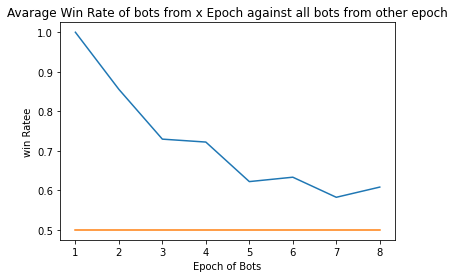

In [ ]:
plt.plot(range(1, len(ans1)+1),ans1)
plt.plot([1, len(ans1)], [0.5,0.5])
plt.xlabel('Epoch of Bots')
plt.ylabel('win Ratee')
plt.title("Avarage Win Rate of bots from x Epoch against all bots from other epoch")

In [ ]:
a = [1, 2]
b = [3, 4]
c = list(np.vstack((a, b)))
b = list()
c

[array([1, 2]), array([3, 4])]

In [ ]:
res

1